# Weak Gravitational Lensing demonstration

Initialize the python environment with the scientific toolkits

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from scipy.ndimage import filters

#astropy package for astronomy
from astropy.units import deg,Mpc,m,lyr
from astropy.constants import G,c
from astropy.cosmology import WMAP9

According to Einsten's General theory of Relativity, light rays traveling through matter get deflected during their path due to the spacetime distortions caused by the matter distribution; if these light rays come from a distant light source, like a galaxy, the galaxy image, as seen from a telescope, will be distorted. We can use these shape distortions to map the dark matter distribution between the source and us, and infer important properties about the physical processes that govern the universe on extragalactic scales. A light ray passing at distance $r$ from a matter point particle of mass $M$ gets deflected by an angle $\alpha=4GM/rc^2$ where

In [2]:
G

<<class 'astropy.constants.codata2014.CODATA2014'> name='Gravitational constant' value=6.67408e-11 uncertainty=3.1e-15 unit='m3 / (kg s2)' reference='CODATA 2014'>

In [3]:
c

<<class 'astropy.constants.codata2014.CODATA2014'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2014'>

We model the 3D dark matter distribution between the source (a galaxy tipically) and the observer (a telescope on earth) as a sequence of point masses arranged on lens planes whose profiles allow to calculate the ray deflections upon each lens crossing. These deflection calculations are carried out with the LensTools package; here's a demo of what this package can do

## Light ray deflection solver

Let's start by importing the LensTools basic functionalities

In [4]:
from lenstools.simulations import PotentialPlane,RayTracer

The dark matter distribution between the observer and the source will cause the apparent shape of the source to be distorted; to calculate the image distortions, we need to carefully trace each light ray through the matter distribution, which we have modeled as a discrete sequence of lenses. First we instantiate our raytracer and load in the information about the matter distribution (modeled as a discrete set of lenses)

In [5]:
tracer = RayTracer(lens_mesh_size=512)

#Add the lenses to the system
for i in range(11,57):
    tracer.addLens(PotentialPlane.load("LensTools Data/lensing/planes/snap{0}_potentialPlane0_normal0.fits".format(i)))
    #tracer.addLens(PotentialPlane.load("LensTools/Test/Data/lensing/planes/snap{0}_potentialPlane0_normal0.fits".format(i)))
    tracer.lens[-1].data *= 20

__Solely__ for demonstration purposes, we boosted the lensing potential by a factor of 20 to emphatize the lensing effect; in a real world example, the ray deflections are __much__ smaller, this is why this kind of gravitational lensing is called _weak_. Next we make sure that the lensed are ordered according to the distance to the observer

In [6]:
#Rearrange the lenses according to redshift and roll them randomly along the axes
tracer.reorderLenses()
tracer.randomRoll()

This is how our lens system (that extends up to redshift $z=2.0$, or distance $w(z)=5291.73$ Mpc) looks like

In [7]:
WMAP9.comoving_distance(z=2.0)

<Quantity 5291.73040581 Mpc>

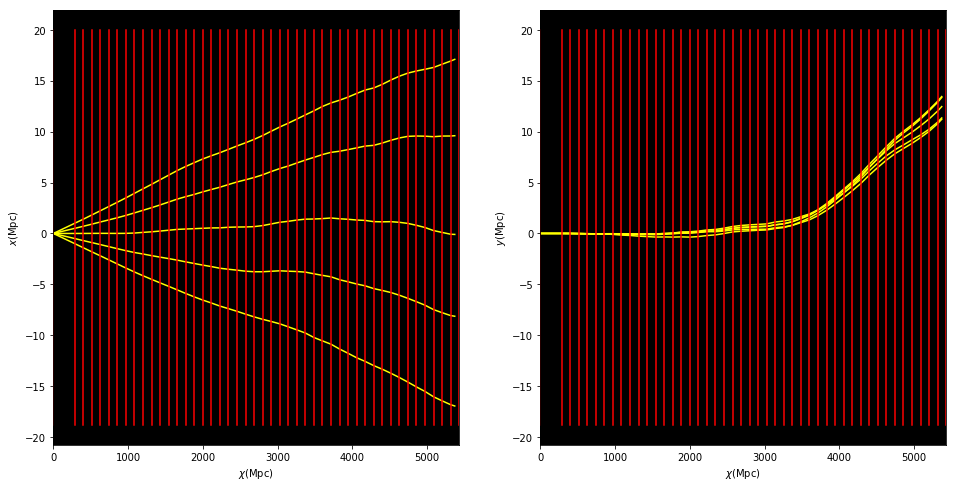

In [8]:
#These are the initial ray positions as they hit the first lens
sample_ray_bucket = np.array([[0.0,-0.1,0.1,-0.2,0.2],[0.0,0.0,0.0,0.0,0.0]]) * deg

#This method computes the light ray deflections through the lenses and displays them schematically
tracer.displayRays(sample_ray_bucket,z=2.0,  raycolor = 'yellow', axisbg = 'black', lenscolor='red')

The length measure units we are using, Mpc, translates into more familiar ones as follows

In [13]:
(1.0 * Mpc).to(m)

<Quantity 3.08567758e+22 m>

In [14]:
(1.0*Mpc).to(lyr)

<Quantity 3261563.77714188 lyr>

In this picture each red line represents a lens and each yellow line represents the trajectory of a light ray through the lens system. In the following we explain how to compute the light ray deflections through the lens system.

### Solving the Lensing ODE

Einstein General Relativity tells us that the light ray path is the solution of the the following differential equation...$$\frac{d^2 \mathbf{x}(w)}{dw^2} = -\frac{2}{c^2}\nabla_{\mathbf{x}}\Phi(\mathbf{x}(w),w)$$ 

where $\mathbf{x}=(x,y)$ are the transverse coordinates and $d$ is the longitudinal coordinate. $\Phi(\mathbf{x},w)$ is the three dimensional gravitational potential that describes the spacetime distortions; in our framework the full profile of $\Phi$ is approximated by a discrete set of finely spaced two dimensional lens planes, for which we can define a two dimensional projected lensing potential $$\Psi(\pmb{\beta},w)\approx \frac{3H_0\Omega_m w\Delta}{2c^2}\Phi(\pmb{\beta}w,w)$$

Where $(H_0,\Omega_m)$ are two of the parameters that describe the $\Lambda$CDM cosmological model of the universe, and have the following values 


In [15]:
(WMAP9.H0,WMAP9.Om0)

(<Quantity 69.32 km / (Mpc s)>, 0.2865)

$w$ is the distance of the lens from the observer and $\Delta$ is the distance between lenses (the red lines above). We work in observer friendly angular coordinates $\pmb{\beta}=\mathbf{x}/w$

This is how a typical $512\times 512$ pixel lens plane looks like; we show both the projected matter density that makes up the lens $\sigma$, along with the lensing potential $\Psi$, which is related to the matter density by the Poisson equation $\nabla^2\Psi(\beta_x,\beta_y) = 2\sigma(\beta_x,\beta_y)$. We measure $\sigma(\beta_x,\beta_y)$ from our simulations and then solve the Poisson equation via FFTs to compute the lensing potential, that allows us to compute the deflection angle of a ray hitting the lens at $(\beta_x,\beta_y)$ as $(\alpha_x,\alpha_y)=(\nabla_{\beta_x}\Psi,\nabla_{\beta_y}\Psi)$

Text(0.5,1,'Lensing potential $\\Psi$')

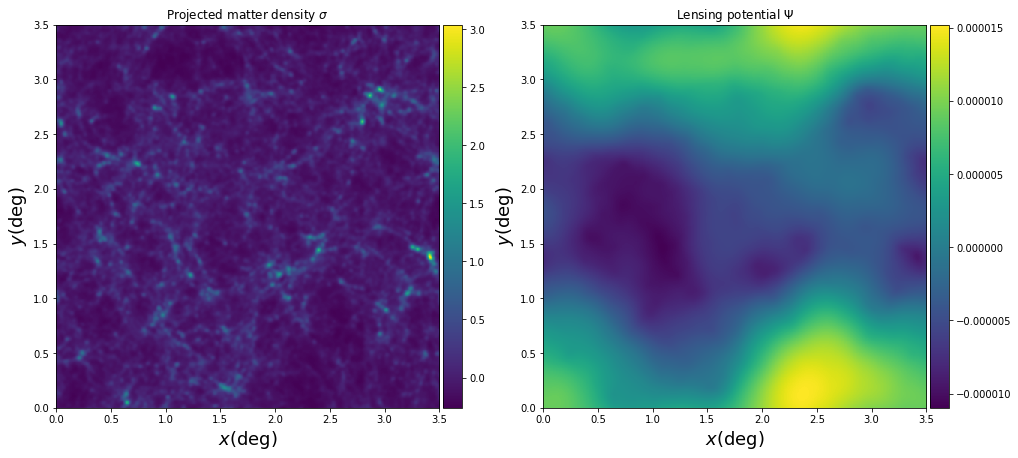

In [113]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

#Compute and visualize the density and corresponding lensing potential
tracer.lens[30].density().visualize(fig,ax[0],colorbar=True)
tracer.lens[30].visualize(fig,ax[1],colorbar=True)

ax[0].set_title(r"Projected matter density $\sigma$")
ax[1].set_title(r"Lensing potential $\Psi$")

The equation for the light trajectories in angular coordinates looks something like $$\frac{d^2\pmb{\beta}(w)}{dw^2} = -\frac{2}{w}\frac{d\pmb{\beta}(w)}{dw} - \frac{1}{w\Delta}\nabla_{\beta}\Psi(\pmb{\beta}(w),w)$$

Which has to be integrated with the following initial conditions

$$\pmb{\beta}(0) = \pmb{\theta} \,\,\, \frac{d\pmb{\beta}}{dw}(0)=0$$

What we are interested in is the final angle, after the final lens has been crossed $\pmb{\beta}_f = \pmb{\beta}(w_f;\pmb{\theta})$

The __tracer.shoot()__ method will do precisely that: it takes in an initial position $\pmb{\theta}$ and integrates the lensing ODE returning the final angle $\pmb{\beta}_f$

In [13]:
theta = np.array([[1.0],[1.5]]) * deg
tracer.shoot(theta,z=2.0)

<Quantity [[ 1.09930956],
           [ 1.56779054]] deg>

## Shape distortions due to lensing

Light ray deflections due to the lenses will cause apparent shape distortions when an observer (usually located on Earth) looks at the source. The lens mapping $\pmb{\theta} \rightarrow \pmb{\beta}(w_f;\pmb{\theta})$ allows us to calculate this shape distortion quantitatively. To start, let's load a sample image that represents the original (unlensed) distribution of sources (each dot is a light ray originating from a source at redshift, for example, $z=2.0$)

Text(0, 0.5, '$\\beta_y$(deg)')

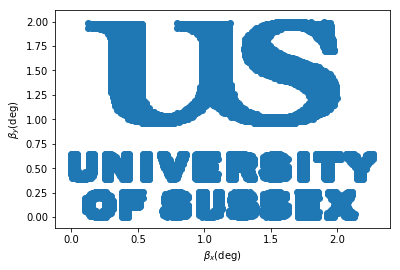

In [9]:
#load unlensed image from png file and discretize it in points
image_unlensed = plt.imread("Sussex Logo.png")[:,:,0]
pos_original = (np.array(np.where(image_unlensed>0)) * 2.0/image_unlensed.shape[0]) * deg
pos_original = np.roll(pos_original,1,axis=0)
pos_original[1] *= -1
pos_original[1] += 2.0*deg

#Visualize the unlensed distribution of sources
fig,ax = plt.subplots()
ax.scatter(pos_original[0],pos_original[1])
ax.set_xlabel(r"$\beta_x$({0})".format(pos_original.unit.to_string()))
ax.set_ylabel(r"$\beta_y$({0})".format(pos_original.unit.to_string()))

To see how this source distributions is distorted by the gravitational lens effect, we need to compute the inverse mapping $\pmb{\theta}(\pmb{\beta}_f)$ (the __tracer.shoot()__ method calculates $\pmb{\beta}_f(\pmb{\theta})$, now we are interested in the inverse problem); this could be quite hard to solve exactly, this is why we adopt an approximate approach: we start from a grid of points at the observer position, $\pmb{\theta}_G$ and we use the ODE solver to compute $\pmb{\beta}_G(\pmb{\theta}_G)$.  

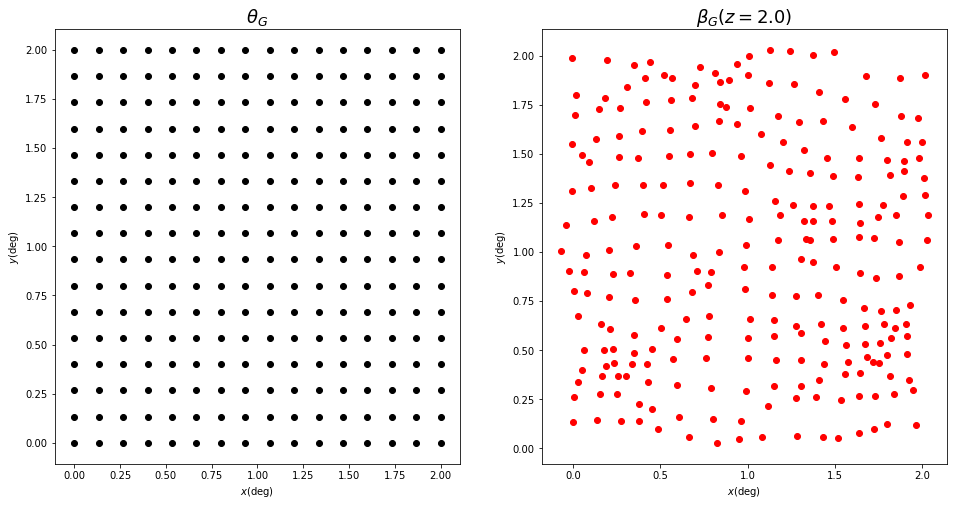

In [10]:
#Regular grid at the observer location
s = np.linspace(0.0,2.0,16)
theta_G = np.array(np.meshgrid(s,s)) * deg
beta_G = tracer.shoot(theta_G,z=2.0)

#This is how the grids look like
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(theta_G[0],theta_G[1],color="black")
ax[0].set_title(r"$\theta_G$",fontsize=18)
ax[1].scatter(beta_G[0],beta_G[1],color="red")
ax[1].set_title(r"$\beta_G(z=2.0)$",fontsize=18)

for i in range(2):
    ax[i].set_xlabel(r"$x$({0})".format(theta_G.unit.to_string()))
    ax[i].set_ylabel(r"$y$({0})".format(theta_G.unit.to_string()))

Next we use a KD Tree based nearest neighbor interpolation scheme to map the unlensed source positions $\pmb{\beta}$ onto the distorted $\pmb{\beta}_G$ for which the inverse mapping $\pmb{\beta}_G\rightarrow\pmb{\theta}_G$ is trivial. This is done by  the __tracer.shootForward()__ which will take care of the ODE solver and the KD tree operations

Text(0, 0.5, '$\\theta_y$(deg)')

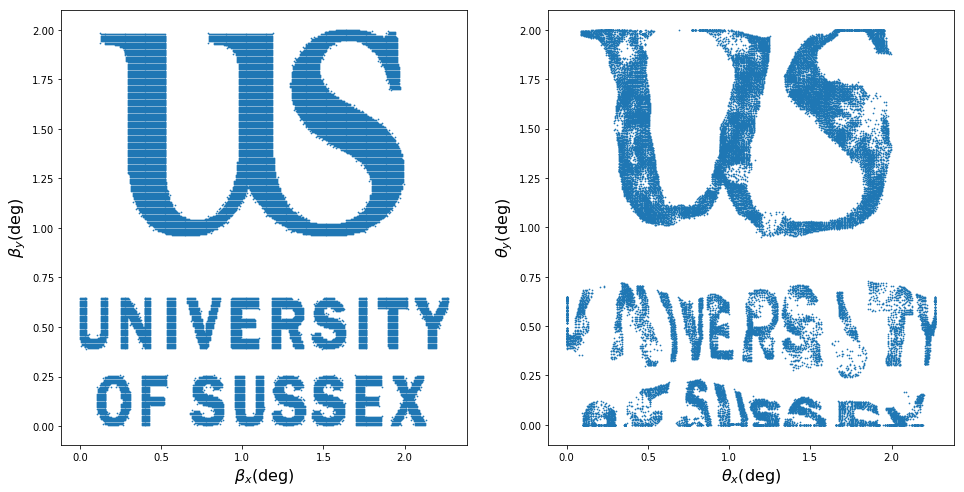

In [29]:
#Perform forward ray tracing with grid interpolation to compute the image distortion
pos_apparent = tracer.shootForward(pos_original,z=2.0)
fig,ax = plt.subplots(1,2,figsize=(16,8))

#Unlensed positions
ax[0].scatter(pos_original[0],pos_original[1], s=0.5)
ax[0].set_xlabel(r"$\beta_x$({0})".format(pos_original.unit.to_string()),fontsize=16)
ax[0].set_ylabel(r"$\beta_y$({0})".format(pos_original.unit.to_string()),fontsize=16)

#Apparent positions
ax[1].scatter(pos_apparent[0],pos_apparent[1], s=0.5)
ax[1].set_xlabel(r"$\theta_x$({0})".format(pos_apparent.unit.to_string()),fontsize=16)
ax[1].set_ylabel(r"$\theta_y$({0})".format(pos_apparent.unit.to_string()),fontsize=16)

This looks a lot nicer if we use a density estimator for the sources instead

In [30]:
from lenstools.extern import _gadget
def densityEstimator(points,grid_size=64):
    
    #Use the LensToold gridding functionality written in C
    pt = np.vstack((points,np.zeros(points.shape[1]))).transpose().astype(np.float32)
    grid_binning = (np.linspace(0.0,2.0,grid_size+1),np.linspace(0.5,1.5,grid_size+1),np.array([-0.1,0.1]))
    density = _gadget.grid3d(pt,grid_binning)
    
    #Smooth the image
    return filters.gaussian_filter(density.sum(-1).transpose(),1)

In [13]:
def densityEstimator(points,grid_size=64):
    H, xedges, yedges  = np.histogram2d(points[0], points[1], bins=grid_size, range=None, normed=None, weights=None, density=True)
    H = H.T # transpose 
    return filters.gaussian_filter(H, sigma=1)

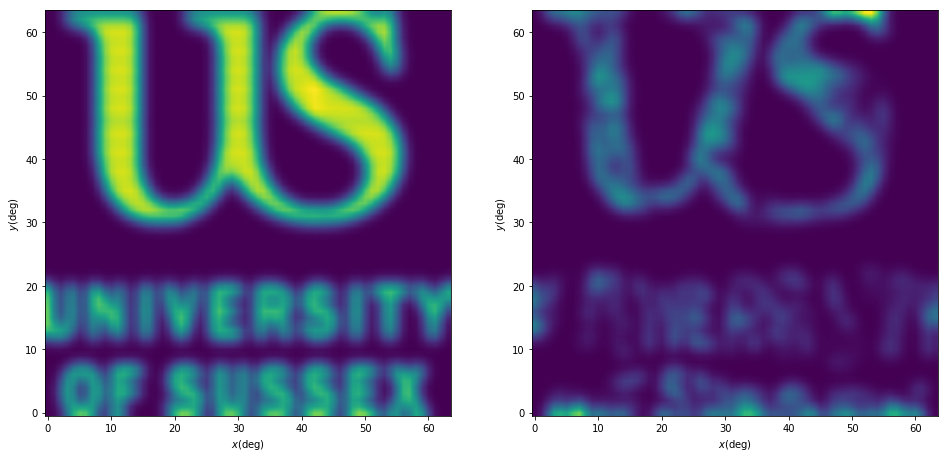

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].imshow(densityEstimator(pos_original,64),origin="lower", interpolation  = 'bilinear') #,extent=(0.0,2.0,0.5,1.5))
ax[1].imshow(densityEstimator(pos_apparent,64),origin="lower",  interpolation  = 'bilinear') #,extent=(0.0,2.0,0.5,1.5))

for i in range(2):
    ax[i].set_xlabel(r"$x$({0})".format(pos_apparent.unit.to_string()))
    ax[i].set_ylabel(r"$y$({0})".format(pos_apparent.unit.to_string()))

The __tracer.shootForward()__ method allows also to save the intermediate image distortions, adding the lenses from the observer to the source one by one, by specifying the save_intermediate keyword (this takes a little bit more time to run though)

In [15]:
#Perform forward ray tracing with grid interpolation to compute the image distortion
pos_apparent = tracer.shootForward(pos_original,z=2.0,save_intermediate=True)

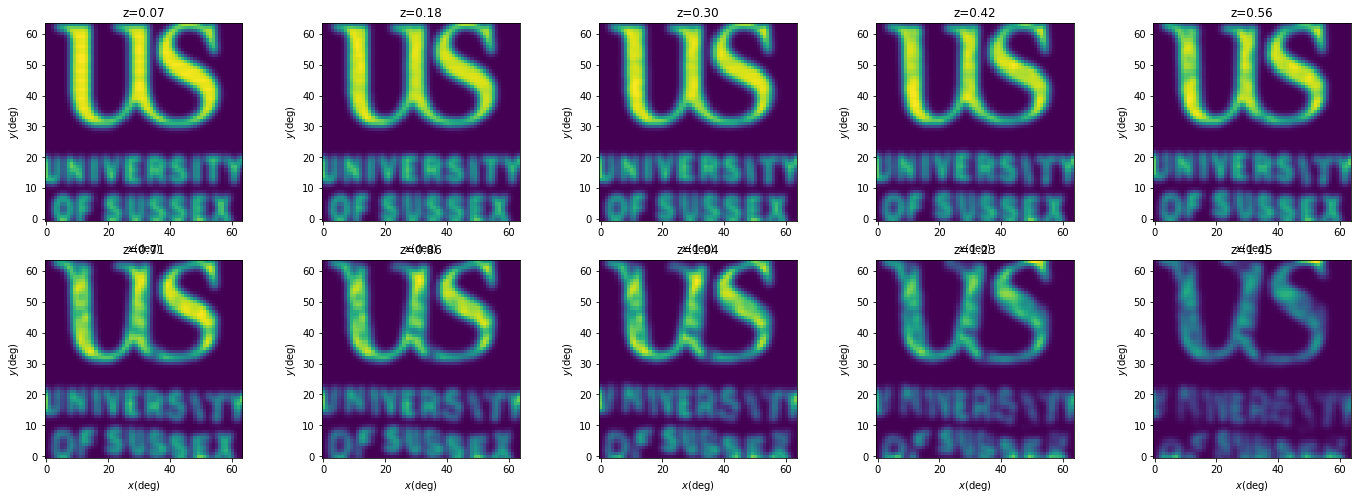

In [16]:
#Plot some of the distorted images
fig,ax = plt.subplots(2,5,figsize=(24,8))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(densityEstimator(pos_apparent[(5*i + j)*4],64),origin="lower") #,extent=(0.4,1.6,0.8,1.2)) 
        ax[i,j].set_xlabel(r"$x$({0})".format(pos_apparent.unit.to_string()))
        ax[i,j].set_ylabel(r"$y$({0})".format(pos_apparent.unit.to_string()))
        ax[i,j].set_title("z={0:.2f}".format(tracer.redshift[(5*i + j)*4]))

How about making a little movie to show how the image distortion evolves in real time?

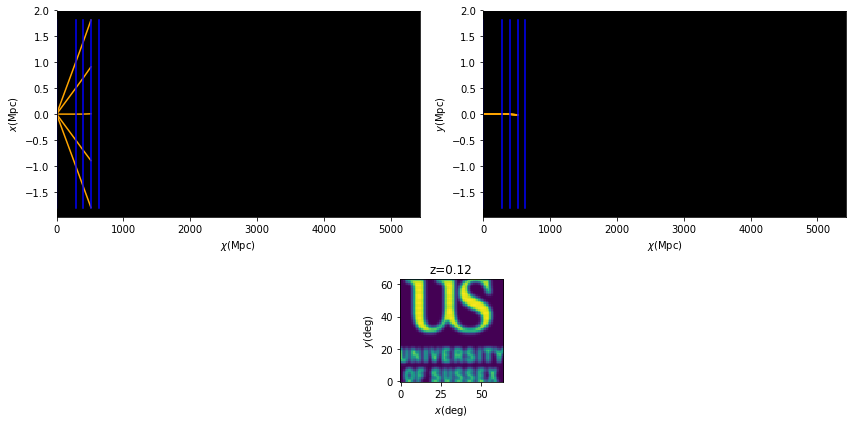

In [17]:
#Arrange the plot panels on the figure
fig = plt.figure(figsize=(12,6))
gs = plt.GridSpec(2,2,height_ratios=[2,1])
ax0 = plt.subplot(gs[0,0],facecolor="black")
ax1 = plt.subplot(gs[0,1],facecolor="black")
ax2 = plt.subplot(gs[1,:],facecolor="black")

#Plot the rays
tracer.reset()
tracer.displayRays(sample_ray_bucket,z=tracer.redshift[2],fig=fig,ax=[ax0,ax1])

#Plot the sources image
image = ax2.imshow(densityEstimator(pos_apparent[0],64),origin="lower") #,extent=(0.0,2.0,0.0,2.0))
ax2.set_xlabel(r"$x$({0})".format(pos_apparent.unit.to_string()))
ax2.set_ylabel(r"$y$({0})".format(pos_apparent.unit.to_string()))
ax2.set_title("z={0:.2f}".format(tracer.redshift[2]))

fig.tight_layout()

In [34]:
from IPython.display import HTML
import matplotlib.animation as animation

In [35]:
#Define the function that updates the animation and makes the movie
def make_lensing_movie(i,tracer,image):
    tracer.displayRays(sample_ray_bucket,z=tracer.redshift[2+i],fig=fig,ax=[ax0,ax1])
    image.set_array(densityEstimator(pos_apparent[i],64))
    image.axes.set_title("z={0:.2f}".format(tracer.redshift[2+i]))
    fig.savefig("frame{0}.png".format(i))

In [38]:
#Instantiate the animation
ani = animation.FuncAnimation(fig,make_lensing_movie,frames=range(pos_apparent.shape[0]-2),fargs=(tracer,image))

#ani.save("lens.m4v",codec="libx264")

In [39]:
HTML(ani.to_html5_video())

StopIteration: 

And finally display the movie

In [126]:
from IPython.display import HTML
from base64 import b64encode

with open("lens.m4v","rb") as video:
    video_encoded = b64encode(video.read())

video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)

FileNotFoundError: [Errno 2] No such file or directory: 'lens.m4v'